# Build a CNN model

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tools import pretraitement
import random
import os
import json
import sys
import time

2021-12-08 14:50:53.397317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 14:50:53.397348: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Chargement du jeu de données
(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = tf.keras.datasets.cifar10.load_data()
assert x_train_origin.shape == (50000, 32, 32, 3)
assert x_test_origin.shape == (10000, 32, 32, 3)
assert y_train_origin.shape == (50000, 1)
assert y_test_origin.shape == (10000, 1)

parametres = { 'data': {
    'x_train_shape': x_train_origin.shape,
    'y_train_shape': y_train_origin.shape,
    'x_test_shape': x_test_origin.shape,
    'y_test_shape': y_test_origin.shape,
    'augmented_data': False
}}

In [3]:
# pretraitement des données
(x_train, y_train) = pretraitement.normalize_dataset(x_train_origin, y_train_origin)

(x_test, y_test) = pretraitement.normalize_dataset(x_test_origin, y_test_origin)

In [4]:
del x_train_origin
del x_test_origin
del y_train_origin
del y_test_origin

In [5]:
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 10)
assert y_test.shape == (10000, 10)

In [11]:
# Construction d'un CNN
def create_model():
    input_shape=(32, 32, 3)

    # La base CNN
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3),padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization(axis=-1))
    model.add(layers.Conv2D(32, (3, 3),padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization(axis=-1))
    model.add(layers.MaxPooling2D((2, 2))) # reduce to 16*16*3

    model.add(layers.Conv2D(64, (3, 3),padding='same', activation='relu'))
    model.add(layers.BatchNormalization(axis=-1))
    model.add(layers.Conv2D(64, (3, 3),padding='same', activation='relu'))
    model.add(layers.BatchNormalization(axis=-1))
    model.add(layers.MaxPooling2D((2, 2))) # reduce to 8*8*3

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization(axis=-1))
    model.add(layers.Conv2D(128, (3, 3),padding='same', activation='relu'))
    model.add(layers.BatchNormalization(axis=-1))
    model.add(layers.MaxPooling2D((2, 2)))  # reduce to 4*4*3

    # Ajout de couches denses vers la fin du model
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model


In [8]:
def get_structure(model):
    model_config = json.loads(model.to_json())

    layers_information = []
    l=model_config['config']['layers']

    for i in range(len(l)):
        layers_information.append({
            'type': l[i]['class_name'],
            'config': l[i]['config']
        })

    return {'layers' : layers_information}

## Model training

In [9]:
# Compiling model

def compil_model(model):
    ## training parameters
    learning_rate = 0.001
    loss='mean_squared_error'
    #loss='categorical_crossentropy'
    optimizers={'adam':Adam(learning_rate=learning_rate)}
    optimizer = 'adam'
    metrics=['accuracy']
    epochs=40
    batch_size=128
    
    model.compile(optimizer=optimizers[optimizer],
                  loss=loss,
                  metrics=metrics)
    
    return model, {
        'learning_rate': learning_rate,
        'loss': loss,
        'optimizer': optimizer,
        'metrics': metrics,
        'epochs': epochs,
        'batch_size': batch_size
    }

## Data augmentation

In [6]:
parametres['data']['augmented_data']=True
parametres['data']['augmentation_param']= {
    'rotation_range':15,
    'horizontal_flip':True,
    'width_shift_range':0.1,
    'height_shift_range':0.1
}


datagen = ImageDataGenerator(**parametres['data']['augmentation_param'])

#datagen.fit(x_train)

In [ ]:
#fit
if (parametres['data']['augmented_data']):
    print("With data augmentation")
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                  steps_per_epoch = len(x_train)/batch_size,epochs=epochs,
                                  validation_data=(x_test,y_test))
else:
    print("Without data augmentation")
    history = model.fit(x_train, y_train, epochs=epochs,batch_size=batch_size, 
                    validation_data=(x_test, y_test))

Without data augmentation
With data augmentation


/home/massy/.local/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-07 21:54:40.676162: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
390/390 [==============================] - 132s 333ms/step - loss: 0.0766 - accuracy: 0.4201 - val_loss: 0.0643 - val_accuracy: 0.5048
Epoch 2/40
390/390 [==============================] - 129s 329ms/step - loss: 0.0599 - accuracy: 0.5480 - val_loss: 0.0523 - val_accuracy: 0.6125
Epoch 3/40
390/390 [==============================] - 127s 325ms/step - loss: 0.0528 - accuracy: 0.6031 - val_loss: 0.0483 - val_accuracy: 0.6472
Epoch 4/40
390/390 [==============================] - 111s 285ms/step - loss: 0.0484 - accuracy: 0.6404 - val_loss: 0.0431 - val_accuracy: 0.6836
Epoch 5/40
390/390 [==============================] - 128s 328ms/step - loss: 0.0453 - accuracy: 0.6650 - val_loss: 0.0448 - val_accuracy: 0.6738
Epoch 6/40
390/390 [==============================] - 130s 334ms/step - loss: 0.0430 - accuracy: 0.6832 - val_loss: 0.0399 - val_accuracy: 0.7125
Epoch 7/40
 99/390 [======>.......................] - ETA: 1:34 - loss: 0.0409 - accuracy: 0.6981

In [12]:
def plot_accuracy(history,h2=None):
    if (h2):
        plt.plot(history.history['accuracy']+h2.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy']+h2.history['val_accuracy'], label = 'val_accuracy')
    else:
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
def plot_loss(history,h2=None):
    if (h2):
        plt.plot(history.history['loss']+h2.history['loss'], label='loss')
        plt.plot(history.history['val_loss']+h2.history['val_loss'], label = 'val_loss')
    else:
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

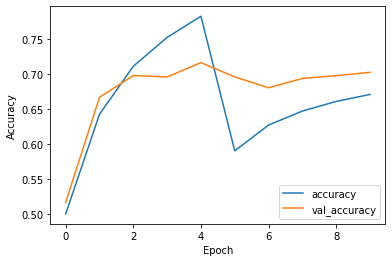

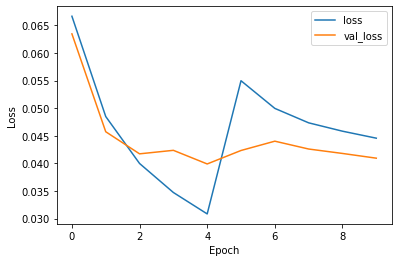

313/313 - 4s - loss: 0.0409 - accuracy: 0.7023
Test accuracy: 0.7023000121116638
Test loss: 0.04094371199607849


2021-12-07 20:58:10.233195: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


1563/1563 - 15s - loss: 0.0370 - accuracy: 0.7324
train accuracy: 0.732420027256012
Train loss: 0.036987509578466415


## Saving the model

lets save the model in an external file 

In [14]:
#json file containing all model informations
def save_in_json(file_name, model, parametres):
    d = '/'.join(file_name.split('/')[0:-1])
    if d:
        d += '/'
        
    if (not os.path.isfile(file_name)):
        data = {}
    else:
        with open(file_name, 'r') as json_file:
            data = json.load(json_file)
    t=str(time.time()).split('.')[0]
    name = d+f'model-{t}.h5'
    
    data[f'model-{t}.h5'] = {
        'time': str(time.time()).split('.')[0],
        'structure': parametres['structure'],
        'training': parametres['training'],
        'data': parametres['data'],
        'results': parametres['results']
    }
    
    with open(file_name, 'w') as json_file:
        json.dump(data, json_file)
    
    # save the model in the file
    model.save(name)

In [15]:
filename = '../saved-models/informations.json'
save_in_json(filename, model, parametres)

In [ ]:
b = {'rotation_range' : [15, 45],
    'horizontal_flip' : [True],
    'vertical_flip' : [True],
    'width_shift_range' : [0.1, 0.3],
    'height_shift_range' : [0.1, 0.3]
     }

default_acc = 0.756
default_loss = 0.041
best_value = {}

for param, values in b.items() :
    best_acc = default_acc
    best_value[param] = None
    for v in values:
        parametres = { 'data': {
          'x_train_shape': x_train.shape,
          'y_train_shape': y_train.shape,
          'x_test_shape': x_test.shape,
          'y_test_shape': y_test.shape,
          'augmented_data': False
        }}
        print(f"Testing on {param} = {v} : ")
        parametres['data']['augmented_data']=True
        parametres['data']['augmentation_param']= {param: v}
        
        datagen = ImageDataGenerator(**parametres['data']['augmentation_param'])
        
        model = create_model()
        parametres['structure'] = get_structure(model)
        model, parametres['training'] = compil_model(model)
        
        history = model.fit_generator(datagen.flow(x_train, y_train, 
                                                   batch_size=parametres['training']['batch_size']),
                                    steps_per_epoch = len(x_train)/parametres['training']['batch_size'],
                                    epochs=parametres['training']['epochs'],
                                  validation_data=(x_test,y_test))
        parametres['results'] = evaluation(model, history)
        
        print(f"Validation accuracy : {parametres['results']['val_acc']}")
        if best_acc < parametres['results']['val_acc']:
            best_acc = parametres['results']['val_acc']
            best_value[param] = v
        
        filename = 'informations.json'
        save_in_json(filename, model, parametres)

        del model
        del parametres
        del history
        del datagen

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


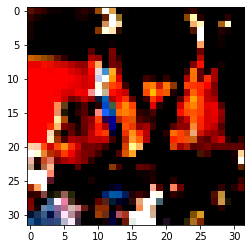

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


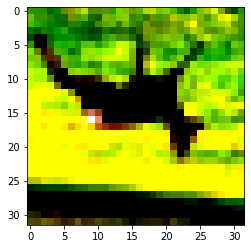

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


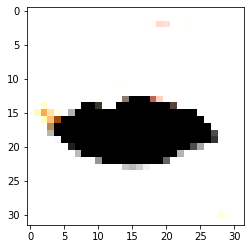

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


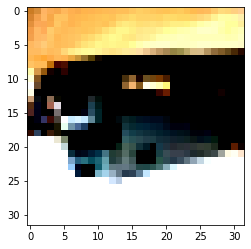

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


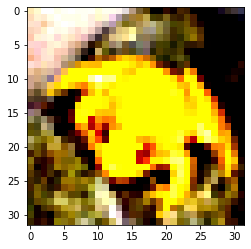

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


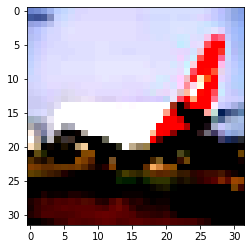

In [14]:
datagen = ImageDataGenerator(vertical_flip=True)

for x, y in datagen.flow(x_train, y_train, batch_size=6):
    for i in range(6):
        plt.imshow(x[i])
        plt.show()
    break